# Source and Sink contributions

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from itertools import compress
import datetime as dt
import seaborn as sns; sns.set()
from datetime import date

%matplotlib notebook

###### Parameters:

In [3]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax-imin
jsize = jmax-jmin

# model results:
results_folder = '/data/brogalla/run_storage/Mn-set4-202004/'
month = 8

# colours:
land_color = "#8b7765"
colors = ['#ccb598', '#367073', '#81a885', '#CC8741', '#cee7fd', '#c7cdd2']

###### Load files:

In [4]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 

e1t_base   = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base   = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t        = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), e3t)

e1t      = np.tile(e1t_base, (50,1,1))
e2t      = np.tile(e2t_base, (50,1,1))
volume   = e1t*e2t*e3t
volume_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), volume)

In [5]:
ref   = nc.Dataset(results_folder+'ref-2003/ANHA12_EXH006_2003_monthly.nc',  'r')
lons  = np.array(ref.variables['nav_lon'])
lats  = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

In [6]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

##### Functions:

In [7]:
def load_results(folder_ref, year):
    
    months  = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    dmn_riv = np.empty((12,isize,jsize))   ; dmn_sed = np.empty((12,isize,jsize)); 
    dmn_atm = np.empty((12,isize,jsize))   ; dmn_ice = np.empty((12,isize,jsize));
    dmn_sedice = np.empty((12,isize,jsize));
    dmn_red = np.empty((12,50,isize,jsize)); dmn_oxi = np.empty((12,50,isize,jsize))
    
    i=0
    for month in months:
        file        = 'ANHA12_EXH006_1m_'+str(year)+'0101_'+str(year)+'1231_comp_'+str(year)+month+'-'+str(year)+month+'.nc'
        ref_monthly = nc.Dataset(folder_ref+file)
        
        dmn_riv[i,:,:]    = np.array(ref_monthly.variables['dmnriv'])[0,:,:]
        dmn_sed[i,:,:]    = np.array(ref_monthly.variables['dmnsed'])[0,:,:]
        dmn_sedice[i,:,:] = np.array(ref_monthly.variables['dmnsedice'])[0,:,:]
        dmn_atm[i,:,:]    = np.array(ref_monthly.variables['dmnatm'])[0,:,:]
        dmn_ice[i,:,:]    = np.array(ref_monthly.variables['dmnice'])[0,:,:]
        dmn_red[i,:,:,:]  = np.array(ref_monthly.variables['dmnred'])[0,:,:,:]
        dmn_oxi[i,:,:,:]  = np.array(ref_monthly.variables['dmnoxi'])[0,:,:,:]
        i+=1
    
    tmask_surf    = np.empty(dmn_riv.shape)
    tmask_surf[:] = tmask[0,:,:]
    tmask_full    = np.empty(dmn_red.shape)
    tmask_full[:] = tmask
    
    # Mask points on land:
    dmn_mriv    = np.ma.masked_where((tmask_surf < 0.1), dmn_riv); 
    dmn_msed    = np.ma.masked_where((tmask_surf < 0.1), dmn_sed)
    dmn_msedice = np.ma.masked_where((tmask_surf < 0.1), dmn_sedice)
    dmn_matm    = np.ma.masked_where((tmask_surf < 0.1), dmn_atm)
    dmn_mice    = np.ma.masked_where((tmask_surf < 0.1), dmn_ice)
    dmn_mred    = np.ma.masked_where((tmask_full < 0.1), dmn_red)
    dmn_moxi    = np.ma.masked_where((tmask_full < 0.1), dmn_oxi)

    return dmn_mriv, dmn_msed, dmn_msedice, dmn_matm, dmn_mice, dmn_mred , dmn_moxi

In [8]:
def plot_year_importance(fig, ax, proj1):
    
    x, y = proj1(lons, lats)
    
    axes=[ax[0,0], ax[0,1], ax[0,2], ax[0,3], \
          ax[1,0], ax[1,1], ax[1,2], ax[1,3], \
          ax[2,0], ax[2,1], ax[2,2], ax[2,3]]
    
    for month in range(0,12):
        riv_imp, sed_imp, sice_imp, red_imp, ice_imp, atm_imp = comp_importance(month, spatial)
        
        sz = 0.1
    
        proj1.plot(x[~atm_imp.mask], y[~atm_imp.mask],'p', markersize=sz,c=colors[0], ax=axes[month]  , zorder=2)
        proj1.plot(x[~red_imp.mask], y[~red_imp.mask],'p', markersize=sz, c=colors[2], ax=axes[month] , zorder=2)
        proj1.plot(x[~sed_imp.mask], y[~sed_imp.mask],'p', markersize=sz, c=colors[3], ax=axes[month] , zorder=2)
        proj1.plot(x[~ice_imp.mask], y[~ice_imp.mask],'p', markersize=sz, c=colors[4], ax=axes[month] , zorder=2)
        proj1.plot(x[~sice_imp.mask], y[~sice_imp.mask],'p', markersize=sz, c=colors[5], ax=axes[month],zorder=2)
        proj1.plot(x[~riv_imp.mask], y[~riv_imp.mask],'p', markersize=sz, c=colors[1], ax=axes[month] , zorder=2)
        
        proj1.plot(x[-1,300:-1], y[-1,300:-1], '-w', linewidth=3, ax=axes[month])
        proj1.plot(x[0,360:500], y[0,360:500], '-w', linewidth=3, ax=axes[month])
        proj1.plot(x[150:-1,-1], y[150:-1,-1], '-w', linewidth=3, ax=axes[month])
        
        proj1.contourf(x, y, land_mask[0,:,:], vmax=0.3, ax=axes[month], \
                       cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=3)
        
        axes[month].set_title(months[month])
    
    return

In [9]:
def comp_importance(month, spatial, output=False): 
    
    riv_prop    = spatial[0,:,:,:]
    sed_prop    = spatial[1,:,:,:]
    sedice_prop = spatial[2,:,:,:]
    ice_prop    = spatial[3,:,:,:]
    atm_prop    = spatial[4,:,:,:]
    red_prop    = spatial[5,:,:,:]
    oxi_prop    = spatial[6,:,:,:]
                                                 
    # Rivers
    riv_imp = np.ma.masked_where((riv_prop[month,:,:] < sed_prop[month,:,:]), riv_prop[month,:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:] < sedice_prop[month,:,:]), riv_imp[:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:] < atm_prop[month,:,:])   , riv_imp[:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:] < ice_prop[month,:,:])   , riv_imp[:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:] < red_prop[month,:,:])   , riv_imp[:,:])

    # Sediment release from ice
    sice_imp = np.ma.masked_where((sedice_prop[month,:,:] < riv_prop[month,:,:]), sedice_prop[month,:,:])
    sice_imp = np.ma.masked_where((sice_imp[:,:] < sed_prop[month,:,:]) , sice_imp[:,:])
    sice_imp = np.ma.masked_where((sice_imp[:,:] < atm_prop[month,:,:]) , sice_imp[:,:])
    sice_imp = np.ma.masked_where((sice_imp[:,:] < ice_prop[month,:,:]) , sice_imp[:,:])
    sice_imp = np.ma.masked_where((sice_imp[:,:] < red_prop[month,:,:]) , sice_imp[:,:])
    
    # Sediment resuspension
    sed_imp = np.ma.masked_where((sed_prop[month,:,:] < riv_prop[month,:,:]), sed_prop[month,:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:] < sedice_prop[month,:,:]), sed_imp[:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:] < atm_prop[month,:,:])   , sed_imp[:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:] < ice_prop[month,:,:])   , sed_imp[:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:] < red_prop[month,:,:])   , sed_imp[:,:])

    # Reduction
    red_imp = np.ma.masked_where((red_prop[month,:,:] < sed_prop[month,:,:]), red_prop[month,:,:])
    red_imp = np.ma.masked_where((red_imp[:,:]  < sedice_prop[month,:,:]), red_imp[:,:])
    red_imp = np.ma.masked_where((red_imp[:,:]  < atm_prop[month,:,:])   , red_imp[:,:])
    red_imp = np.ma.masked_where((red_imp[:,:]  < ice_prop[month,:,:])   , red_imp[:,:])
    red_imp = np.ma.masked_where((red_imp[:,:]  < riv_prop[month,:,:])   , red_imp[:,:])

    # Dust from ice
    ice_imp = np.ma.masked_where((ice_prop[month,:,:] < sed_prop[month,:,:]), ice_prop[month,:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < sedice_prop[month,:,:]), ice_imp[:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < atm_prop[month,:,:])   , ice_imp[:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < riv_prop[month,:,:])   , ice_imp[:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < red_prop[month,:,:])   , ice_imp[:,:])

    # Dust directly from atmosphere
    atm_imp = np.ma.masked_where((atm_prop[month,:,:] < sed_prop[month,:,:]), atm_prop[month,:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < sedice_prop[month,:,:]), atm_imp[:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < riv_prop[month,:,:])   , atm_imp[:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < ice_prop[month,:,:])   , atm_imp[:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < red_prop[month,:,:])   , atm_imp[:,:])
    
    
    # Mask all places where the maximum contribution is very small:
    threshold = 5e-8
    riv_imp  = np.ma.masked_where((riv_imp[:,:]  < threshold), riv_imp[:,:] )
    sice_imp = np.ma.masked_where((sice_imp[:,:] < threshold), sice_imp[:,:])
    sed_imp  = np.ma.masked_where((sed_imp[:,:]  < threshold), sed_imp[:,:] )
    red_imp  = np.ma.masked_where((red_imp[:,:]  < threshold), red_imp[:,:] )
    ice_imp  = np.ma.masked_where((ice_imp[:,:]  < threshold), ice_imp[:,:] )
    atm_imp  = np.ma.masked_where((atm_imp[:,:]  < threshold), atm_imp[:,:] )

    if output:
        print('Rivers       --- Masked values before: ', np.ma.count_masked(riv_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(riv_imp[:,:]))
        print('Rivers       --- Non-masked values:    ', np.ma.count(riv_imp[:,:]))
        print('Sediment     --- Masked values before: ', np.ma.count_masked(sed_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(sed_imp[:,:]))
        print('Sediment     --- Non-masked values:    ', np.ma.count(sed_imp[:,:]))
        print('Sediment ice --- Masked values before: ', np.ma.count_masked(sedice_prop[month,:,:]), ', after: ', \
        np.ma.count_masked(sice_imp[:,:]))
        print('Sediment ice --- Non-masked values:    ', np.ma.count(sice_imp[:,:]))
        print('Reduction    --- Masked values before: ', np.ma.count_masked(red_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(red_imp[:,:]))
        print('Reduction    --- Non-masked values:    ', np.ma.count(red_imp[:,:]))
        print('Dust ice     --- Masked values before: ', np.ma.count_masked(ice_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(ice_imp[:,:]))
        print('Dust ice     --- Non-masked values:    ', np.ma.count(ice_imp[:,:]))
        print('Dust direct  --- Masked values before: ', np.ma.count_masked(atm_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(atm_imp[:,:]))
        print('Dust direct  --- Non-masked values:    ', np.ma.count(atm_imp[:,:]))

    return riv_imp, sed_imp, sice_imp, red_imp, ice_imp, atm_imp

In [10]:
def calculate_contribution(year, output=False):
    # Calculate the contribution of the model components to Canada Basin specifically
    
    
    folder_year = 'ref-'+str(year)+'/'
    dmn_mriv, dmn_msed, dmn_msedice, dmn_matm, dmn_mice, dmn_mred, dmn_moxi = load_results(results_folder+\
                                                                                           folder_year, year)
    # moles per second
    riv    = dmn_mriv    * volume_masked[0,:,:] * 1e3
    sed    = dmn_msed    * volume_bottom * 1e3
    sedice = dmn_msedice * volume_masked[0,:,:] * 1e3
    atm    = dmn_matm    * volume_masked[0,:,:] * 1e3
    ice    = dmn_mice    * volume_masked[0,:,:] * 1e3
    red    = np.ma.average(dmn_mred[:,0:17,:,:] * volume_masked[0:17,:,:]* 1e3, axis=1) 
    oxi    = np.ma.average(dmn_moxi[:,0:17,:,:] * volume_masked[0:17,:,:]* 1e3, axis=1) 
    
    # moles per meter squared per second
    rivm2    = dmn_mriv    * e3t_masked[0,:,:] * 1e3
    sedm2    = dmn_msed    * e3t_bottom * 1e3
    sedicem2 = dmn_msedice * e3t_masked[0,:,:] * 1e3
    atmm2    = dmn_matm    * e3t_masked[0,:,:] * 1e3
    icem2    = dmn_mice    * e3t_masked[0,:,:] * 1e3
    redm2    = np.ma.average(dmn_mred[:,0:17,:,:]* e3t_masked[0:17,:,:]*1e3, axis=1) #average contribution over PML
    oxim2    = np.ma.average(dmn_moxi[:,0:17,:,:]* e3t_masked[0:17,:,:]*1e3, axis=1) #average contribution over PML
    
    # Total monthly contribution to domain: (moles per month)
    atm_mnth    = np.ma.sum(atm[:,:,:], axis=(1,2))   *3600*24*30
    riv_mnth    = np.ma.sum(riv[:,:,:], axis=(1,2))   *3600*24*30
    sed_mnth    = np.ma.sum(sed[:,:,:], axis=(1,2))   *3600*24*30
    sedice_mnth = np.ma.sum(sedice[:,:,:], axis=(1,2))*3600*24*30
    ice_mnth    = np.ma.sum(ice[:,:,:], axis=(1,2))   *3600*24*30
    red_mnth    = np.ma.sum(red[:,:,:], axis=(1,2))   *3600*24*30
    oxi_mnth    = np.ma.sum(oxi[:,:,:], axis=(1,2))   *3600*24*30
    
    # Average monthly contribution over domain: (moles per meter squared per month)
    atmm2_mnth    = np.ma.average(atmm2[:,:,:], axis=(1,2))   *3600*24*30
    rivm2_mnth    = np.ma.average(rivm2[:,:,:], axis=(1,2))   *3600*24*30
    sedm2_mnth    = np.ma.average(sedm2[:,:,:], axis=(1,2))   *3600*24*30
    sedicem2_mnth = np.ma.average(sedicem2[:,:,:], axis=(1,2))*3600*24*30
    icem2_mnth    = np.ma.average(icem2[:,:,:], axis=(1,2))   *3600*24*30
    redm2_mnth    = np.ma.average(redm2[:,:,:], axis=(1,2))   *3600*24*30
    oxim2_mnth    = np.ma.average(oxim2[:,:,:], axis=(1,2))   *3600*24*30

    total_monthly_contribution = np.vstack((riv_mnth, sed_mnth, sedice_mnth, ice_mnth, \
                                            atm_mnth, red_mnth, oxi_mnth))           # mol/mnth
    ave_monthly_contribution   = np.vstack((rivm2_mnth, sedm2_mnth, sedicem2_mnth, icem2_mnth, \
                                            atmm2_mnth, redm2_mnth, oxim2_mnth))     # mol/m2/mnth
    monthly_contribution = np.vstack((rivm2*3600*24*30, sedm2*3600*24*30, sedicem2*3600*24*30, icem2*3600*24*30, \
                                      atmm2*3600*24*30, redm2*3600*24*30, oxim2*3600*24*30))
    
    monthly_contribution = monthly_contribution.reshape(7, 12, isize, jsize)
    
    return total_monthly_contribution, ave_monthly_contribution, monthly_contribution

##### Calculations:

Calculate the moles of Mn contributed to each grid cell

In [11]:
tmask_bot = np.copy(tmask)
tmask_bot[0,:,:] = 1
e3t_mask = np.ma.masked_where((tmask_bot[:,:,:] < 0.1), e3t[:,:,:])

# find bottom grid cell index:
ind = np.array(np.ma.notmasked_edges(e3t_mask[:,:,:], axis=0))

# array of shape (isize, jsize) containing bottom grid cell index
index_bottom = np.ma.masked_where((tmask[0,:,:] < 0.1), ind[1][0][:].reshape(isize,jsize))

In [12]:
e3t_bot = np.zeros((isize,jsize))
vol_bot = np.zeros((isize,jsize))

for i in range(0, isize):
    for j in range(0,jsize):
        k = index_bottom[i,j]
        try:
            e3t_bot[i,j] = e3t[k,i,j]
            vol_bot[i,j] = volume[k,i,j]
        except:
            e3t_bot[i,j] = np.nan
            vol_bot[i,j] = np.nan
        
e3t_bottom    = np.ma.masked_where((tmask[0,:,:] < 0.1), np.ma.masked_where(np.isnan(e3t_bot), e3t_bot))
volume_bottom = np.ma.masked_where((tmask[0,:,:] < 0.1), np.ma.masked_where(np.isnan(vol_bot), vol_bot))

In [13]:
# total_2003, ave_2003, spatial_2003 = calculate_contribution(2003, output=False)
# total_2004, ave_2004, spatial_2004 = calculate_contribution(2004, output=False)
# total_2005, ave_2005, spatial_2005 = calculate_contribution(2005, output=False)
# total_2006, ave_2006, spatial_2006 = calculate_contribution(2006, output=False)
# total_2007, ave_2007, spatial_2007 = calculate_contribution(2007, output=False)
# total_2008, ave_2008, spatial_2008 = calculate_contribution(2008, output=False)
# total_2009, ave_2009, spatial_2009 = calculate_contribution(2009, output=False)
# total_2010, ave_2010, spatial_2010 = calculate_contribution(2010, output=False)
# total_2011, ave_2011, spatial_2011 = calculate_contribution(2011, output=False)
# total_2012, ave_2012, spatial_2012 = calculate_contribution(2012, output=False)
# total_2013, ave_2013, spatial_2013 = calculate_contribution(2013, output=False)
# total_2014, ave_2014, spatial_2014 = calculate_contribution(2014, output=False)
total_2015, ave_2015, spatial_2015 = calculate_contribution(2015, output=False)
# total_2016, ave_2016, spatial_2016 = calculate_contribution(2016, output=False)
# total_2017, ave_2017, spatial_2017 = calculate_contribution(2017, output=False)
# total_2018, ave_2018, spatial_2018 = calculate_contribution(2018, output=False)
# total_2019, ave_2019, spatial_2019 = calculate_contribution(2019, output=False)

##### Bar plot of monthly components

In [14]:
average_2015 = ave_2015*1e6 # micromols

<IPython.core.display.Javascript object>


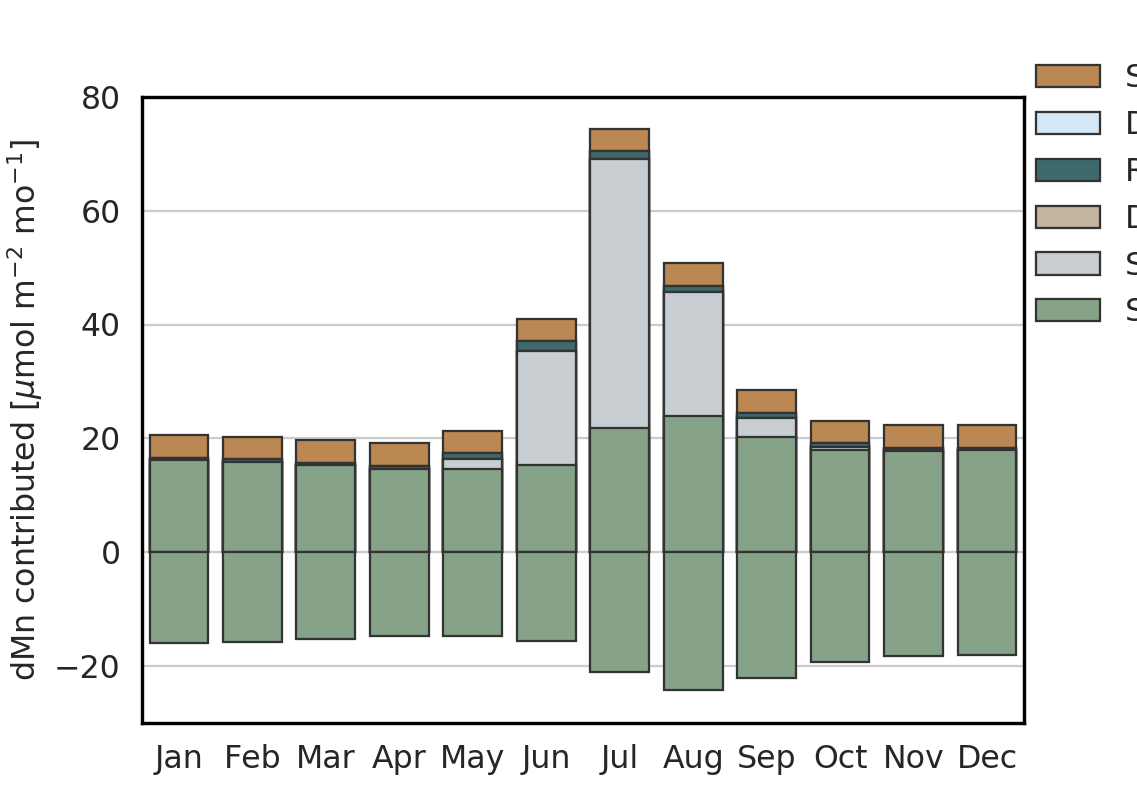

In [15]:
fig = plt.figure(figsize=(7,5))
st  = sns.axes_style("whitegrid")

with st:
    # sediment:
    icp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], \
                     average_2015[5,:] + average_2015[2,:] + average_2015[4,:] + average_2015[0,:] + average_2015[3,:] + average_2015[1,:],\
                     color=colors[3], edgecolor=".2", label='Sediment resuspension')
    # ice:
    rip= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], \
                     average_2015[5,:] + average_2015[2,:] + average_2015[4,:] + average_2015[0,:] + average_2015[3,:], \
                     color=colors[4], edgecolor=".2", label='Dust released by ice')
    # rivers:
    sep= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], \
                     average_2015[5,:] + average_2015[2,:] + average_2015[4,:] + average_2015[0,:], \
                     color=colors[1], edgecolor=".2", label='Rivers')
    # dust:
    dup= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], \
                     average_2015[5,:] + average_2015[2,:] + average_2015[4,:], \
                     color=colors[0], edgecolor=".2", label='Dust deposition')
    
    # sediment in ice:
    icp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], \
                     average_2015[5,:] + average_2015[2,:], \
                     color=colors[5], edgecolor=".2", label='Sediment released by ice') 

    # Scavenging:
    scp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], \
                     average_2015[5,:], \
                     color=colors[2], edgecolor=".2", label='Scavenging') 
    scn= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], \
                     -average_2015[6,:], \
                     color=colors[2], edgecolor=".2") 
    
    icp.set_ylabel(r'dMn contributed [$\mu$mol m$^{-2}$ mo$^{-1}$]', fontsize=14)
    icp.set(ylim=(-30,80))
    icp.tick_params(axis='both', which='major', labelsize=14)
    icp.spines['left'].set_linewidth(1.5);   icp.spines['left'].set_color('black');
    icp.spines['bottom'].set_linewidth(1.5); icp.spines['bottom'].set_color('black');
    icp.spines['right'].set_linewidth(1.5);  icp.spines['right'].set_color('black');
    icp.spines['top'].set_linewidth(1.5);    icp.spines['top'].set_color('black');    
    
    icp.legend(loc=(1.0, 0.61), fontsize=14, frameon=False)
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/R4-source-sink-budget-' + \
            str(date.today().strftime('%Y%m%d')) + '.png', bbox_inches='tight',dpi=300)

##### Figure of spatial variation in component importance:

Sum the contribution of each model component over the course of a year

In [16]:
riv_imp, sed_imp, sedice_imp, red_imp, ice_imp, atm_imp = comp_importance(7, spatial_2015, output=True)

Rivers       --- Masked values before:  0 , after:  447181
Rivers       --- Non-masked values:     819
Sediment     --- Masked values before:  0 , after:  440000
Sediment     --- Non-masked values:     8000
Sediment ice --- Masked values before:  0 , after:  360923
Sediment ice --- Non-masked values:     87077
Reduction    --- Masked values before:  0 , after:  309549
Reduction    --- Non-masked values:     138451
Dust ice     --- Masked values before:  0 , after:  447854
Dust ice     --- Non-masked values:     146
Dust direct  --- Masked values before:  0 , after:  448000
Dust direct  --- Non-masked values:     0


In [17]:
ice_imp = np.ma.masked_where((tmask[0,:,:] < 0.1), ice_imp)

Only include contributions above 0.2 nM:

<IPython.core.display.Javascript object>


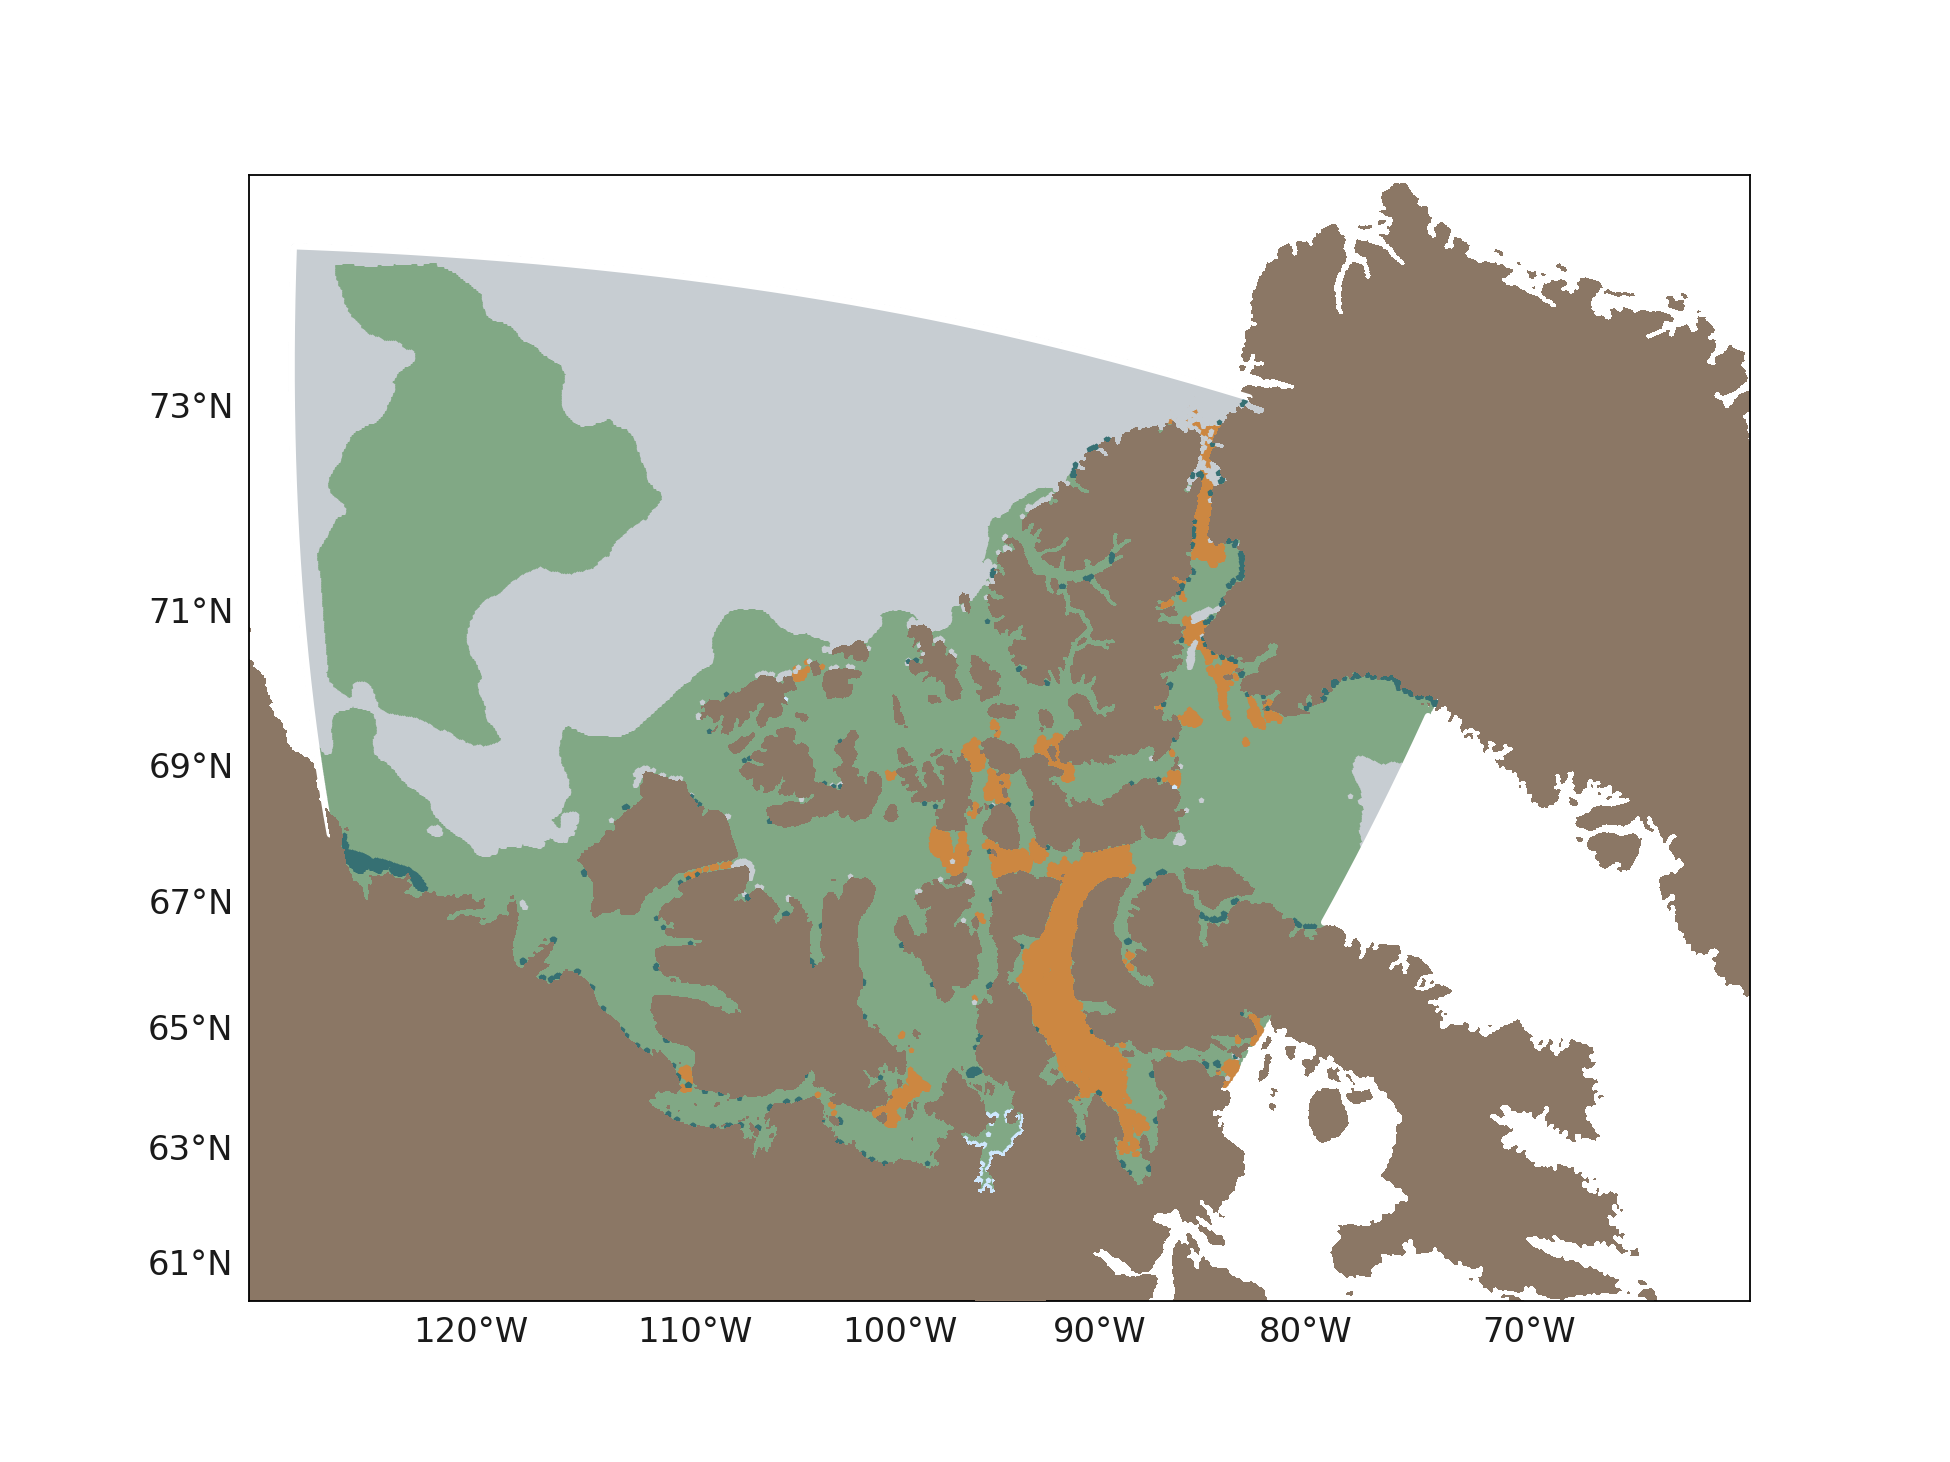

In [18]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-zoom.pickle','rb'))

ax1.set_frame_on(True)

x, y = proj1(lons, lats)
    
sz = 1.5
    
proj1.plot(x[~atm_imp.mask], y[~atm_imp.mask],'p'  , markersize=sz, c=colors[0], zorder=2)
proj1.plot(x[~red_imp.mask], y[~red_imp.mask],'p'  , markersize=sz, c=colors[2], zorder=2)
proj1.plot(x[~sed_imp.mask], y[~sed_imp.mask],'p'  , markersize=sz, c=colors[3], zorder=2)
proj1.plot(x[~ice_imp.mask], y[~ice_imp.mask],'p'  , markersize=sz, c=colors[4], zorder=2)
proj1.plot(x[~sedice_imp.mask], y[~sedice_imp.mask],'p', markersize=sz, c=colors[5], zorder=2)
proj1.plot(x[~riv_imp.mask], y[~riv_imp.mask],'p'  , markersize=sz, c=colors[1], zorder=2)

proj1.plot(x[-1,300:-1], y[-1,300:-1], '-w', linewidth=3)
proj1.plot(x[0,360:500], y[0,360:500], '-w', linewidth=3)
proj1.plot(x[150:-1,-1], y[150:-1,-1], '-w', linewidth=3)
        
proj1.contourf(x, y, land_mask[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=3)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/R4-source-sink-map-' + \
            str(date.today().strftime('%Y%m%d')) + '.png', bbox_inches='tight',dpi=300)

Without considering reduction:

### By water mass

- Polar mixed layer (0-40 m)
    - PML depth levels = 1 to 17
- Pacific/halocline water (40-300 m)
    - PW depth levels = 17 to 29
- Atlantic water (300-800 m)
    - AW depth levels = 29 to 35
- Deep water (> 800 m)
    - DW depth levels = 35-50